In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

c:\Users\dsouz\DSW-Project\.venv311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data Preparation
df = pd.read_csv("../cleaned_reddit_posts.csv")
drop_cols = ['score', 'upvote_ratio', 'sort_type', 'id', 'author', 'selftext']
df = df.drop(columns=drop_cols)


In [3]:
tfidf = TfidfVectorizer(max_features=1000)
X_title_tfidf = tfidf.fit_transform(df['title']).toarray()

In [4]:
label_enc_cols = ['subreddit', 'flair', 'media_type']
for col in label_enc_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [5]:
target_le = LabelEncoder()
df['popularity_bucket'] = target_le.fit_transform(df['popularity_bucket'])

In [6]:
tfidf_df = pd.DataFrame(
    X_title_tfidf,
    columns=[f'tfidf_{i}' for i in range(X_title_tfidf.shape[1])],
    index=df.index
)

In [7]:
structured_df = df.drop(columns=['popularity_bucket', 'title'])
X = pd.concat([tfidf_df, structured_df], axis=1)
y = df['popularity_bucket']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [9]:
# Baseline: majority class
majority_class = Counter(y_train).most_common(1)[0][0]
print("Majority class in training data:", majority_class)

y_pred_baseline = np.full_like(y_test, fill_value=majority_class)
print("\nBaseline Performance (Majority Class):")
print("Accuracy:", round(accuracy_score(y_test, y_pred_baseline), 4))
print("F1 Score (macro):", round(f1_score(y_test, y_pred_baseline, average='macro'), 4))

Majority class in training data: 0

Baseline Performance (Majority Class):
Accuracy: 0.3398
F1 Score (macro): 0.1691


In [10]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print("Baseline XGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

c:\Users\dsouz\DSW-Project\.venv311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:19:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Baseline XGBoost Performance:
Accuracy: 0.8398009950248756
F1 Score (macro): 0.8402179901619452

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83       683
           1       0.93      0.94      0.93       664
           2       0.75      0.78      0.76       663

    accuracy                           0.84      2010
   macro avg       0.84      0.84      0.84      2010
weighted avg       0.84      0.84      0.84      2010



In [11]:
# 5-Fold CV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False, random_state=42)
    model.fit(X_tr, y_tr)

    y_pred_fold = model.predict(X_val_fold)
    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = f1_score(y_val_fold, y_pred_fold, average='macro')

    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"Fold {fold} - Accuracy: {acc:.4f} | F1 Score (macro): {f1:.4f}")

print("\nK-Fold CV Results (5 folds):")
print(f"Avg Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Avg F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

c:\Users\dsouz\DSW-Project\.venv311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:20:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1 - Accuracy: 0.8246 | F1 Score (macro): 0.8243


c:\Users\dsouz\DSW-Project\.venv311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:20:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 - Accuracy: 0.8377 | F1 Score (macro): 0.8384


c:\Users\dsouz\DSW-Project\.venv311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:20:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3 - Accuracy: 0.8314 | F1 Score (macro): 0.8316


c:\Users\dsouz\DSW-Project\.venv311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:20:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4 - Accuracy: 0.8289 | F1 Score (macro): 0.8292


c:\Users\dsouz\DSW-Project\.venv311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5 - Accuracy: 0.8301 | F1 Score (macro): 0.8304

K-Fold CV Results (5 folds):
Avg Accuracy: 0.8305 ± 0.0042
Avg F1 Score: 0.8308 ± 0.0045


In [12]:
# Optuna hyperparameter tuning
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0),
        'random_state': 42,
        #'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='macro')
    return f1

study = optuna.create_study(direction='maximize', sampler=TPESampler(), pruner=MedianPruner())
study.optimize(objective, n_trials=30)

print("Best trial:")
print(f"  F1 Score: {study.best_value}")
print("  Best hyperparameters:")
for key, val in study.best_params.items():
    print(f"    {key}: {val}")

[I 2025-07-13 21:21:18,933] A new study created in memory with name: no-name-945fe3ad-dc22-40e4-b744-566ebc429650
c:\Users\dsouz\DSW-Project\.venv311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-07-13 21:21:57,294] Trial 0 finished with value: 0.8337528627783541 and parameters: {'n_estimators': 427, 'max_depth': 3, 'learning_rate': 0.18276492543679954, 'subsample': 0.5870270116415525, 'colsample_bytree': 0.6604992457743122, 'gamma': 2.1905809752177827, 'reg_lambda': 0.012111951842161975, 'reg_alpha': 7.914972676744597}. Best is trial 0 with value: 0.8337528627783541.
c:\Users\dsouz\DSW-Project\.venv311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.u

Best trial:
  F1 Score: 0.8445341735906905
  Best hyperparameters:
    n_estimators: 153
    max_depth: 7
    learning_rate: 0.02485458150558259
    subsample: 0.6549573855010098
    colsample_bytree: 0.6271332651289346
    gamma: 4.05812341458172
    reg_lambda: 0.8369193922796077
    reg_alpha: 1.1385221094575617


In [13]:
# Retrain final model with best params
best_params = study.best_trial.params
best_params.update({
    "objective": "multi:softprob",
    "num_class": len(target_le.classes_),
    "use_label_encoder": False,
    "eval_metric": "mlogloss"
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

y_test_pred_best = final_model.predict(X_test)

print("Final Evaluation After Tuning:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_best))
print("F1 Score (macro):", f1_score(y_test, y_test_pred_best, average='macro'))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_best))

c:\Users\dsouz\DSW-Project\.venv311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:47:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Evaluation After Tuning:
Accuracy: 0.8422885572139304
F1 Score (macro): 0.8430622811427765

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       683
           1       0.94      0.93      0.93       664
           2       0.75      0.79      0.77       663

    accuracy                           0.84      2010
   macro avg       0.84      0.84      0.84      2010
weighted avg       0.84      0.84      0.84      2010



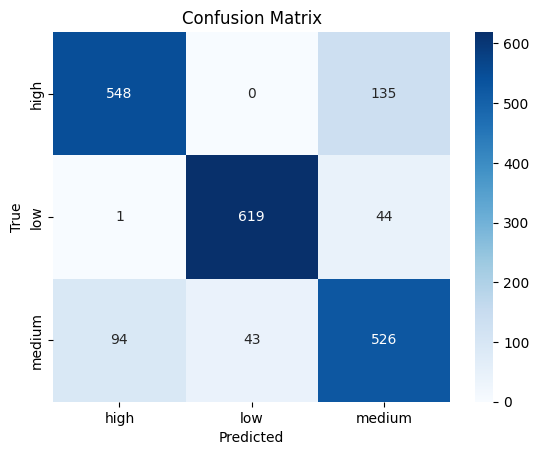

In [14]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_test_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_le.classes_, yticklabels=target_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

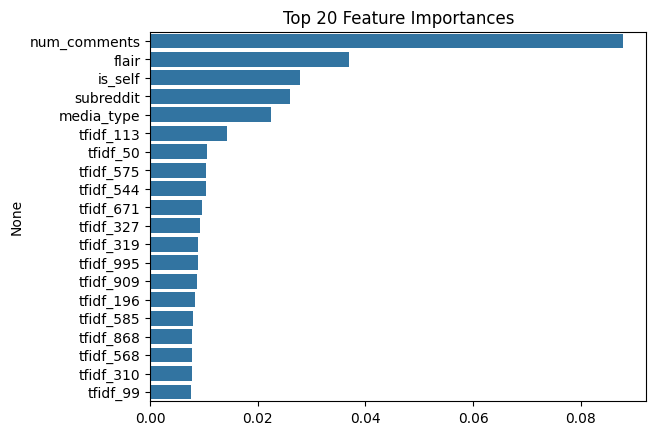

In [15]:
# Feature importance plot
importances = final_model.feature_importances_
top_idx = importances.argsort()[-20:][::-1]
top_features = X.columns[top_idx]

sns.barplot(x=importances[top_idx], y=top_features)
plt.title("Top 20 Feature Importances")
plt.show()